<html>
   <head>
      <title>Clustering</title>
   </head>
   <body>
      <h1><font size="5">Part 3: Clustering</font></h1>
      <ul style="list-style-type:none;line-height: 2;">
         <li><font size="3"><a href='#1'>1. Clustering of User Data</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#1.1'>1.1 Preparation for Kmeans</a></font></li>
             <li><font size="3"><a href='#1.2'>1.2 Elbow Method</a></font></li>
             <li><font size="3"><a href='#1.3'>1.3 Score Function</a></font></li>
             <li><font size="3"><a href='#1.4'>1.4 Clustering and Evalutation</a></font></li>
                 <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
                 <li><font size="3"><a href='#1.4.1'>1.4.1 Unscaled</a></font></li>
                 <li><font size="3"><a href='#1.4.2'>1.4.2 Standard Scaled</a></font></li>
                 <li><font size="3"><a href='#1.4.3'>1.4.3 MinMax Scaled</a></font></li>
                 </ul> 
             </ul>          
         <li><font size="3"><a href='#2'>2. Segmenting Customers by RFM</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#2.1'>2.1 Recency</a></font></li>
             <li><font size="3"><a href='#2.2'>2.2 Frequency</a></font></li>
             <li><font size="3"><a href='#2.3'>2.3 Monetary Value</a></font></li>
             <li><font size="3"><a href='#2.4'>2.4 Overall User Score</a></font></li>
             </ul>          
      </ul>
   </body>
</html>

In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture


In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

## Loading Dataframes

In [3]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_user = pd.read_pickle("./Data/users.pickle")
df_month = pd.read_pickle("./Data/months.pickle")

In [4]:
df_user_std = df_user.copy()
df_user_mm = df_user.copy()

In [5]:
df_user.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany


In [6]:
df_month.head()

,year_month,revenue,monthly_growth_revenue,avg_shop_cart,avg_cart_itemcount,active_customers,total_purchases,women_article,men_article,kids_article,homeandliving_article,revenue_first,revenue_established,first_user_count,established_user_count,retained_user_count,retention_rate,ratio_first_to_established
0,201711,5.268517e+06,0.000000,103.495016,3.466743,46985,50906,96910,61491,14107,999,5.268517e+06,0.00,46985,0,46985,1.000000,0.000000
1,201712,4.983451e+06,-0.054108,90.652698,3.284649,50004,54973,95202,64962,15461,1806,4.619641e+06,363809.47,46799,3205,3205,0.064095,14.601872
2,201801,3.717325e+06,-0.254066,87.034361,3.661563,38221,42711,89365,52416,10983,1100,3.216473e+06,500851.97,33596,4625,3141,0.082180,7.264000
3,201802,3.056483e+06,-0.177773,90.680675,3.791995,30837,33706,67535,42438,14910,795,2.526812e+06,529670.62,26114,4723,2520,0.081720,5.529113
4,201803,6.210612e+06,1.031947,108.247849,3.966274,52209,57374,139458,66852,18202,964,5.122223e+06,1088389.01,44512,7697,2797,0.053573,5.783032


<a id='1'></a>

## 1. Clustering of User Data

<a id='1.1'></a>

## 1.1 Preparation for Kmeans (dummies and scaling)

In [5]:
user_dum = pd.get_dummies(df_user.drop(columns=["user_id", "region", "city","country"]))
#region and city need to be dropped as the computing power needed to do this exceeds the given

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_scale_std = scaler.fit_transform(user_dum)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_scale_mm = scaler.fit_transform(user_dum)

<a id='1.2'></a>

## 1.2 Elbow method 

In [6]:
#function to get the name of a dataframe (for plotting reasons)
def get_df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

In [7]:
#function to plot the elbow graph for one to nine clusters
def elbow(data):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_jobs=-1).fit(data)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("Elbow plot for {}".format(get_df_name(data)))
    plt.xlabel("Number of cluster")
    plt.show()

In [8]:
#function to plot the elbow graph for one to nine clusters and save the clusters in the dataframe
def elbow_withsave(data):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_jobs=-1).fit(data)
        data["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("Elbow plot for {}".format(get_df_name(data)))
    plt.xlabel("Number of cluster")
    plt.show()

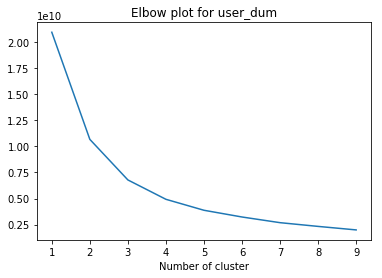

In [13]:
#elbow for unscaled data
elbow(user_dum)

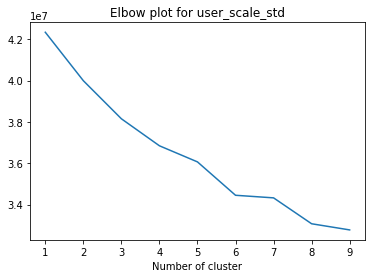

In [14]:
#elbow for standard scaler
elbow(user_scale_std)

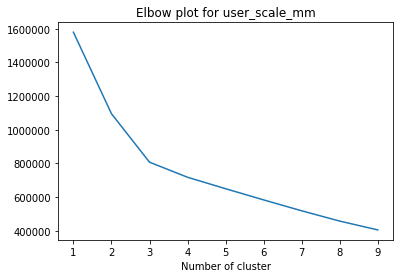

In [15]:
#elbow for minmax scaler
elbow(user_scale_mm)

<a id='1.3'></a>

## 1.3 Score Function

In [9]:
#plot multiple scores for kmeans of specific data
def getscores(data):
    km_scores = []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
    for i in range(2,10):
        km = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(data)
        preds = km.predict(data)
    
        print("Score for number of cluster(s) {}: {}".format(i,km.score(data)))
        km_scores.append(-km.score(data))
    
        #silhouette = silhouette_score(data,preds)
        #km_silhouette.append(silhouette)
        #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
        
        #Silhouette score is commented out as it needs too much computation power and time
    
        db = davies_bouldin_score(data,preds)
        db_score.append(db)
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
        #v_measure = v_measure_score(y,preds)
        #vmeasure_score.append(v_measure)
        #print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
        #print("-"*100)
        
        #same as for Silhouette above

    plt.figure(figsize=(7,4))
    plt.title("The elbow method for determining number of clusters\n",fontsize=16)
    plt.scatter(x=[i for i in range(2,10)],y=km_scores,s=150,edgecolor='k')
    plt.grid(True)
    plt.xlabel("Number of clusters",fontsize=14)
    plt.ylabel("K-means score",fontsize=15)
    plt.xticks([i for i in range(2,12)],fontsize=14)
    plt.yticks(fontsize=15)
    plt.show()
    
    plt.figure(figsize=(7,4))
    plt.scatter(x=[i for i in range(2,10)],y=db_score,s=150,edgecolor='k')
    plt.grid(True)
    plt.xlabel("Davies-Bouldin score")
    plt.show()        

<a id='1.4'></a>

## 1.4 Clustering and Evaluation

In [10]:
#function to order the clusters produced by the ML 
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final



<a id='1.4.1'></a>

## 1.4.1 Unscaled

In [11]:
kmeans = KMeans(n_clusters=4, max_iter=1000, n_jobs=-1)
kmeans.fit(user_dum)
df_user['cluster'] = kmeans.predict(user_dum)

In [12]:
df_user_wcluster = order_cluster('cluster', 'revenue',df_user,True)

In [13]:
df_user_wcluster.groupby('cluster').describe()

avg_cart_itemcount                                           \
                     count      mean       std  min   25%       50%   
cluster                                                               
0                 426331.0  2.399971  1.693625  1.0  1.00  2.000000   
1                 154198.0  5.636155  3.297139  1.0  3.00  5.000000   
2                  38735.0  8.683555  5.150227  1.0  4.80  7.500000   
3                   3353.0  7.344472  4.393632  1.0  4.35  6.333333   

                         avg_shop_cart                                     \
               75%   max         count        mean         std        min   
cluster                                                                     
0         3.000000  29.0      426331.0   56.260600   28.188656   0.000000   
1         7.000000  35.0      154198.0  162.350217   58.816022  20.408462   
2        11.333333  54.0       38735.0  270.466949  132.473380  27.126111   
3         9.250000  62.0        3353.0  212.035179  130.983709  34.235172   

                                                  friday                      \
                25%      50%      75%      max     count      mean       std   
cluster                                                                        
0         33.610000   50.410   75.610   122.76  426331.0  0.153709  0.366918   
1        126.030000  152.900  198.930   312.06  154198.0  0.191896  0.426660   
2        157.950000  254.595  362.985  1001.06   38735.0  0.337860  0.613724   
3        127.299286  183.380  263.455  2099.47    3353.0  1.195944  1.404504   

                                  homeandliving_article                      \
         min  25%  50%  75%   max                 count      mean       std   
cluster                                                                       
0        0.0  0.0  0.0  0.0   4.0              426331.0  0.020740  0.197530   
1        0.0  0.0  0.0  0.0   6.0              154198.0  0.028094  0.302139   
2        0.0  0.0  0.0  1.0   6.0               38735.0  0.049387  0.444135   
3        0.0  0.0  1.0  2.0  15.0                3353.0  0.188488  1.005782   

                                  kids_article                                \
         min  25%  50%  75%   max        count      mean       std  min  25%   
cluster                                                                        
0        0.0  0.0  0.0  0.0  10.0     426331.0  0.281378  1.172258  0.0  0.0   
1        0.0  0.0  0.0  0.0  13.0     154198.0  0.512380  2.115521  0.0  0.0   
2        0.0  0.0  0.0  0.0  20.0      38735.0  0.997702  3.536665  0.0  0.0   
3        0.0  0.0  0.0  0.0  19.0       3353.0  2.676707  7.362169  0.0  0.0   

                         men_article                                       \
         50%  75%    max       count       mean        std  min  25%  50%   
cluster                                                                     
0        0.0  0.0   37.0    426331.0   1.001862   1.653927  0.0  0.0  0.0   
1        0.0  0.0   44.0    154198.0   2.396536   3.576356  0.0  0.0  0.0   
2        0.0  0.0   85.0     38735.0   4.993262   6.821003  0.0  0.0  2.0   
3        0.0  1.0  125.0      3353.0  11.495079  16.231527  0.0  1.0  5.0   

                        monday                                                \
          75%    max     count      mean       std  min  25%  50%  75%   max   
cluster                                                                        
0         2.0   27.0  426331.0  0.135885  0.347850  0.0  0.0  0.0  0.0   4.0   
1         4.0   37.0  154198.0  0.170080  0.401456  0.0  0.0  0.0  0.0   6.0   
2         8.0   76.0   38735.0  0.290074  0.565636  0.0  0.0  0.0  0.0   7.0   
3        16.0  209.0    3353.0  1.000298  1.255418  0.0  0.0  1.0  1.0  12.0   

          revenue                                                      \
            count         mean         std     min       25%      50%   
cluster                                        

In [14]:
df_user_wcluster.groupby(["cluster"]).agg({
    "revenue": ["count", "mean", "sum"],
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": "mean",
    #"user_type": "mode"  
})#.round(0)

revenue                            women_article men_article  \
          count         mean           sum           sum         sum   
cluster                                                                
0        426331    61.645107  2.628122e+07        569588      427125   
1        154198   203.872059  3.143666e+07        663472      369541   
2         38735   491.791279  1.904954e+07        413073      193414   
3          3353  1417.785652  4.753835e+06        121615       38543   

        kids_article homeandliving_article avg_shop_cart total_purchases  \
                 sum                   sum          mean            mean   
cluster                                                                    
0             119960                  8842     56.260600        1.120266   
1              79008                  4332    162.350217        1.465577   
2              38646                  1913    270.466949        2.606144   
3               8975                   632    212.035179        9.097226   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 2.399971  0.135885  0.151326  0.128987  0.162512  0.153709   
1                 5.636155  0.170080  0.192175  0.169451  0.211546  0.191896   
2                 8.683555  0.290074  0.339899  0.288060  0.375268  0.337860   
3                 7.344472  1.000298  1.162541  0.977930  1.337012  1.195944   

         saturday    sunday  
             mean      mean  
cluster                      
0        0.181120  0.199437  
1        0.236177  0.277546  
2        0.436711  0.494282  
3        1.527885  1.617059

#TD cluster 0 and 1 denote only about 2% of the customers, but these have the highest value <br>
cluster 2 has 57000 users , about 9% of the customers, are still valueable, mostly those customers that purchase more often<br>
cluster 3 a bit more than a average of 1 time customers, but with a way higher avg. purchase value than cluster 4, abput 27% <br> 
cluster 4 customers who mostly bought only once, about 61%

<a id='1.4.2'></a>

## 1.4.2 Standard Scaled

In [24]:
kmeans = KMeans(n_clusters=3, max_iter=1000, n_jobs=-1)
kmeans.fit(user_scale_std)
df_user_std['cluster'] = kmeans.predict(user_scale_std)

In [25]:
ordered_by_rev_std = order_cluster('cluster', 'revenue',df_user_std,False)

In [26]:
ordered_by_rev_std.groupby('cluster').describe()

avg_cart_itemcount                                                     \
                     count      mean       std  min  25%       50%  75%   max   
cluster                                                                         
0                  82853.0  4.063804  2.807518  1.0  2.0  3.333333  5.0  62.0   
1                 240780.0  3.779657  3.375368  1.0  2.0  3.000000  5.0  54.0   
2                 298984.0  3.366352  3.089804  1.0  1.0  2.000000  4.0  38.0   

        avg_shop_cart                                                          \
                count        mean        std  min      25%    50%         75%   
cluster                                                                         
0             82853.0  105.181515  72.756009  0.0  54.3550  85.82  135.086667   
1            240780.0   98.554377  85.670580  0.0  40.3300  71.40  126.030000   
2            298984.0   92.856744  81.141069  0.0  37.9975  67.21  117.630000   

                    friday                                                \
             max     count      mean       std  min  25%  50%  75%   max   
cluster                                                                    
0        2099.47   82853.0  0.413359  0.683828  0.0  0.0  0.0  1.0  15.0   
1        1159.57  240780.0  0.145726  0.354957  0.0  0.0  0.0  0.0   2.0   
2         975.48  298984.0  0.143426  0.352429  0.0  0.0  0.0  0.0   3.0   

        homeandliving_article                                                \
                        count      mean       std  min  25%  50%  75%   max   
cluster                                                                       
0                     82853.0  0.051428  0.430540  0.0  0.0  0.0  0.0  20.0   
1                    240780.0  0.022410  0.229710  0.0  0.0  0.0  0.0  16.0   
2                    298984.0  0.020275  0.214335  0.0  0.0  0.0  0.0  12.0   

        kids_article                                                 \
               count      mean       std  min  25%  50%  75%    max   
cluster                                                               
0            82853.0  0.968812  3.359787  0.0  0.0  0.0  0.0  125.0   
1           240780.0  0.296021  1.354480  0.0  0.0  0.0  0.0   44.0   
2           298984.0  0.317890  1.384229  0.0  0.0  0.0  0.0   37.0   

        men_article                                                   monday  \
              count      mean       std  min  25%  50%  75%    max     count   
cluster                                                                        
0           82853.0  3.580148  6.257593  0.0  0.0  1.0  5.0  209.0   82853.0   
1          240780.0  1.649635  2.711807  0.0  0.0  0.0  2.0   50.0  240780.0   
2          298984.0  1.119786  2.193875  0.0  0.0  0.0  1.0   35.0  298984.0   

                                                        revenue              \
             mean       std  min  25%  50%  75%   max     count        mean   
cluster                                                                       
0        0.359504  0.629711  0.0  0.0  0.0  1.0  12.0   82853.0  328.793834   
1        0.134712  0.343297  0.0  0.0  0.0  0.0   2.0  240780.0  103.734233   
2        0.122167  0.328631  0.0  0.0  0.0  0.0   3.0  298984.0   98.007150   

                                                              saturday  \
                std  min     25%     50%       75%       max     count   
cluster                                                                  
0        323.208745  0.0  136.93  237.77  411.0400  21205.01   82853.0   
1         92.514942  0.0   41.97   74.78  133.5900   1160.34  240780.0   
2         87.575581  0.0   39.30   68.20  125.6825    975.48  298984.0   

                                                         sunday            \
             mean       std  min  25%  50%  75%   max     count      mean   
cluster                                                                     
0        0.538641  0.817581  0.0  0.0  0.0 

seems that there is no good outcome whatsoever with a standardscaler.

In [27]:
df_user_std.groupby(["cluster"]).agg({
    "revenue": ["count", "mean", "sum"],
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue                           women_article men_article  \
          count        mean           sum           sum         sum   
cluster                                                               
0         82853  328.793834  2.724156e+07        668795      296626   
1        240780  103.734233  2.497713e+07        476263      397199   
2        298984   98.007150  2.930257e+07        622690      334798   

        kids_article homeandliving_article avg_shop_cart total_purchases  \
                 sum                   sum          mean            mean   
cluster                                                                    
0              80269                  4261    105.181515        3.186861   
1              71276                  5396     98.554377        1.055844   
2              95044                  6062     92.856744        1.059515   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 4.063804  0.359504  0.421638  0.346783  0.472246  0.413359   
1                 3.779657  0.134712  0.144235  0.127070  0.156321  0.145726   
2                 3.366352  0.122167  0.138967  0.121174  0.147690  0.143426   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.538641  0.588971   82853  
1        0.151321  0.189090  240780  
2        0.182655  0.194204  298984

<a id='1.4.3'></a>

## 1.4.3 MinMax Scaled

In [28]:
kmeans = KMeans(n_clusters=3, max_iter=1000, n_jobs=-1)
kmeans.fit(user_scale_mm)
df_user_mm['cluster'] = kmeans.predict(user_scale_mm)

In [29]:
ordered_by_rev_mm = order_cluster('cluster', 'revenue',df_user_mm,False)

In [30]:
ordered_by_rev_mm.groupby('cluster').describe()

avg_cart_itemcount                                                \
                     count      mean       std  min  25%  50%  75%   max   
cluster                                                                    
0                 191443.0  3.393970  2.991120  1.0  1.0  2.0  4.0  43.0   
1                 275431.0  3.831712  3.321261  1.0  2.0  3.0  5.0  62.0   
2                 155743.0  3.519423  3.121613  1.0  1.0  2.5  4.5  42.0   

        avg_shop_cart                                                       \
                count       mean        std  min    25%        50%     75%   
cluster                                                                      
0            191443.0  92.638682  78.457174  0.0  39.98  67.220000  117.64   
1            275431.0  99.554831  84.470894  0.0  42.01  73.923333  127.71   
2            155743.0  96.644433  81.572287  0.0  41.17  71.183333  124.33   

                    friday                                                \
             max     count      mean       std  min  25%  50%  75%   max   
cluster                                                                    
0         975.48  191443.0  0.189884  0.439953  0.0  0.0  0.0  0.0   9.0   
1        2099.47  275431.0  0.178985  0.420348  0.0  0.0  0.0  0.0  15.0   
2        1138.39  155743.0  0.170589  0.405873  0.0  0.0  0.0  0.0  10.0   

        homeandliving_article                                                \
                        count      mean       std  min  25%  50%  75%   max   
cluster                                                                       
0                    191443.0  0.021897  0.248692  0.0  0.0  0.0  0.0  20.0   
1                    275431.0  0.026497  0.264318  0.0  0.0  0.0  0.0  16.0   
2                    155743.0  0.027154  0.263069  0.0  0.0  0.0  0.0  13.0   

        kids_article                                                 \
               count      mean       std  min  25%  50%  75%    max   
cluster                                                               
0           191443.0  0.404794  1.846299  0.0  0.0  0.0  0.0  125.0   
1           275431.0  0.370989  1.701508  0.0  0.0  0.0  0.0   85.0   
2           155743.0  0.429631  1.846337  0.0  0.0  0.0  0.0   59.0   

        men_article                                                   monday  \
              count      mean       std  min  25%  50%  75%    max     count   
cluster                                                                        
0          191443.0  1.377930  3.039601  0.0  0.0  0.0  2.0  195.0  191443.0   
1          275431.0  1.988992  3.652573  0.0  0.0  1.0  3.0  209.0  275431.0   
2          155743.0  1.393308  2.941176  0.0  0.0  0.0  2.0   84.0  155743.0   

                                                        revenue              \
             mean       std  min  25%  50%  75%   max     count        mean   
cluster                                                                       
0        0.159113  0.400923  0.0  0.0  0.0  0.0  10.0  191443.0  132.311223   
1        0.164666  0.402059  0.0  0.0  0.0  0.0  12.0  275431.0  131.711294   
2        0.147249  0.376460  0.0  0.0  0.0  0.0  11.0  155743.0  127.863360   

                                                          saturday            \
                std  min    25%    50%     75%       max     count      mean   
cluster                                                                        
0        170.898484  0.0  42.01  80.66  157.09   6267.30  191443.0  0.242908   
1        157.694202  0.0  44.52  84.02  159.65   6112.63  275431.0  0.193805   
2        166.397869  0.0  42.01  80.65  152.47  21205.01  155743.0  0.229808   

                                               sunday                      \
              std  min  25%  50%  75%   max     count      mean       std   
cluster                                                                     
0        0.510701  0.0  0.0  0.0  0.0  12.0  191443.0  

In [31]:
df_user_mm.groupby(["cluster"]).agg({
    "revenue": ["count", "mean", "sum"],
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue                           women_article men_article  \
          count        mean           sum           sum         sum   
cluster                                                               
0        275431  131.711294  3.627737e+07        735637      547830   
1        155743  127.863360  1.991382e+07        441063      216998   
2        191443  132.311223  2.533006e+07        591048      263795   

        kids_article homeandliving_article avg_shop_cart total_purchases  \
                 sum                   sum          mean            mean   
cluster                                                                    
0             102182                  7298     99.554831        1.316119   
1              66912                  4229     96.644433        1.297972   
2              77495                  4192     92.638682        1.412405   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 3.831712  0.164666  0.178055  0.155371  0.195069  0.178985   
1                 3.519423  0.147249  0.169889  0.143082  0.185562  0.170589   
2                 3.393970  0.159113  0.186536  0.159207  0.200033  0.189884   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.193805  0.239174  275431  
1        0.229808  0.241032  155743  
2        0.242908  0.255825  191443

<a id='2'></a>

## 2. Segmenting Customers by RFM (Recency, Frequency, Monetary Value)

<a id='2.1'></a>

### 2.1 Recency

In [15]:
#create a dataframe to keep user_id and new segmentation scores
user_scores = pd.DataFrame(df['user_id'].unique())
user_scores.columns = ['user_id']

#most recent purchase date for each customer
recent_purchase = df.groupby('user_id').date.max().reset_index()
recent_purchase.columns = ['user_id','most_recent_purchase']

#we take our observation point as the max invoice date in our dataset
recent_purchase['recency'] = (recent_purchase['most_recent_purchase'].max() - recent_purchase['most_recent_purchase']).dt.days

#merge this dataframe to our new user dataframe
user_scores = pd.merge(user_scores, recent_purchase[['user_id','recency']], on='user_id')


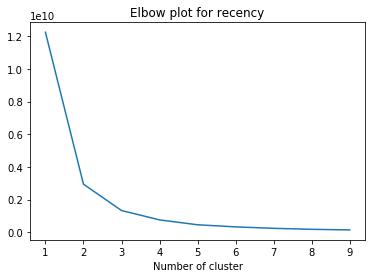

In [16]:
#elbow for recency
recency = user_scores[['recency']]
elbow_withsave(recency)

Score for number of cluster(s) 2: -2945153925.1975646
Davies Bouldin score for number of cluster(s) 2: 0.4842518018975964
Score for number of cluster(s) 3: -1331572780.1891394
Davies Bouldin score for number of cluster(s) 3: 0.5009166703790123
Score for number of cluster(s) 4: -755841607.1759416
Davies Bouldin score for number of cluster(s) 4: 0.5199597112067611
Score for number of cluster(s) 5: -457718161.81622595
Davies Bouldin score for number of cluster(s) 5: 0.5053284122290754
Score for number of cluster(s) 6: -328290241.30246586
Davies Bouldin score for number of cluster(s) 6: 0.4997569294947814
Score for number of cluster(s) 7: -238583575.7689658
Davies Bouldin score for number of cluster(s) 7: 0.4981555455036511
Score for number of cluster(s) 8: -177377110.60466173
Davies Bouldin score for number of cluster(s) 8: 0.492174125241969
Score for number of cluster(s) 9: -139366448.76741296
Davies Bouldin score for number of cluster(s) 9: 0.49208639310105196


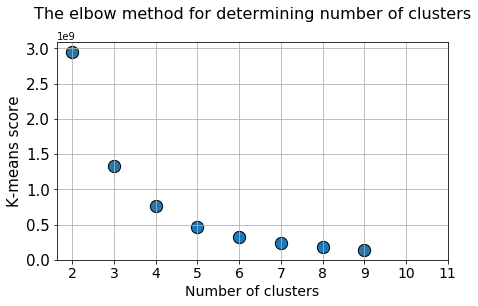

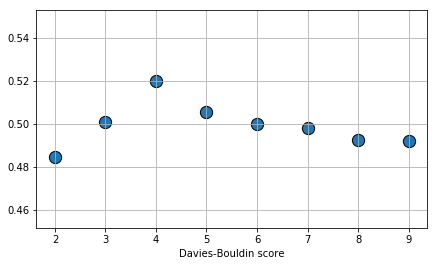

In [34]:
getscores(recency)

In [17]:
#there seems to be the choice between 3 and 4 clusters. Three will be the choice from here on (arbitrarily chosen).
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_scores[['recency']])
user_scores['recency_cluster'] = kmeans.predict(user_scores[['recency']])


user_scores = order_cluster('recency_cluster', 'recency',user_scores,False)

#see details of each cluster
user_scores.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,169451.0,410.295643,45.684057,334.0,368.0,415.0,451.0,484.0
1,186874.0,256.862324,44.250640,174.0,222.0,258.0,294.0,333.0
2,266292.0,89.229635,47.806093,0.0,52.0,94.0,128.0,173.0


<a id='2.2'></a>

### 2.2 Frequency

In [18]:
#get order counts for each user and create a dataframe with it; same as total_purchases in df_user
frequency_purch = df.groupby('user_id')['visit_id'].nunique().reset_index()
frequency_purch.columns = ['user_id','frequency']

#add this data to our main dataframe
user_scores = pd.merge(user_scores, frequency_purch, on='user_id')


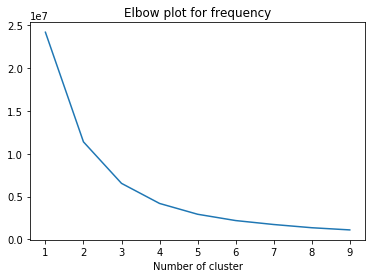

In [12]:
#elbow for frequency
frequency = user_scores[['frequency']]
elbow(frequency)

In [19]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_scores[['frequency']])
user_scores['frequency_cluster'] = kmeans.predict(user_scores[['frequency']])

#order the frequency cluster
user_scores = order_cluster('frequency_cluster', 'frequency',user_scores,True)

#see details of each cluster
user_scores.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,581146.0,1.119991,0.324951,1.0,1.0,1.0,1.0,2.0
1,38132.0,3.797572,1.103855,3.0,3.0,3.0,4.0,7.0
2,3339.0,11.787361,6.192659,8.0,8.0,10.0,13.0,126.0


<a id='2.3'></a>

### 2.3 Monetary Value

In [20]:
#calculate monetary value for each customer
mon_val = df.groupby('user_id').total_price.sum().reset_index()

#merge it with our main dataframe
user_scores = pd.merge(user_scores, mon_val, on='user_id')
user_scores = user_scores.rename(columns={"total_price": "monetary_value"})

In [21]:
#elbow for monetary_value
mon = user_scores[['monetary_value']]
#getscores(mon)
#elbow(mon)

In [22]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_scores[['monetary_value']])
user_scores['monetary_value_cluster'] = kmeans.predict(user_scores[['monetary_value']])

#order the monetary value cluster
user_scores = order_cluster('monetary_value_cluster', 'monetary_value',user_scores,True)

#see details of each cluster
user_scores.groupby('monetary_value_cluster')['monetary_value'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_value_cluster,,,,,,,,
0,514857.0,78.608791,48.529573,0.00,38.6500,67.210,109.240,204.35
1,100636.0,329.967489,115.062277,204.36,240.7375,293.815,386.490,715.95
2,7124.0,1100.836554,544.521621,716.13,805.6825,932.620,1197.235,21205.01


<a id='2.4'></a>

### 2.4 Overall User Score

In [23]:
#calculate overall score and use mean() to see details
user_scores['score'] = user_scores['recency_cluster'] + user_scores['frequency_cluster'] + user_scores['monetary_value_cluster']
user_scores.groupby('score')['recency','frequency','monetary_value'].mean()

,recency,frequency,monetary_value
score,,,
0,411.321819,1.063453,77.725409
1,273.613737,1.125091,98.593608
2,111.140034,1.179813,103.730319
3,114.037163,1.900570,307.719436
4,87.525734,3.992452,441.824848
5,79.588153,6.204402,900.952578
6,50.427164,13.164334,1442.276527


In [24]:
#segment the scores into value categories
user_scores['value_segment'] = 'low'
user_scores.loc[user_scores['score']>2,'value_segment'] = 'mid' 
user_scores.loc[user_scores['score']>4,'value_segment'] = 'high' 

In [25]:
user_scores.head()

,user_id,recency,recency_cluster,frequency,frequency_cluster,monetary_value,monetary_value_cluster,score,value_segment
0,553811,171,2,1,0,30.0,0,2,low
1,130862,68,2,1,0,50.0,0,2,low
2,158533,150,2,1,0,30.0,0,2,low
3,512073,164,2,1,0,80.0,0,2,low
4,461386,80,2,1,0,30.0,0,2,low


In [26]:
#add scores and segment to user data and save it as new pickle
df_user_wscore = pd.merge(df_user_wcluster, user_scores[["user_id", "recency", "frequency", "score", "value_segment"]], on="user_id")

In [27]:
df_user_wscore.to_pickle("Data/users_with_score.pickle")
user_scores.to_pickle("Data/user_scores.pickle")

## Gaussian Mixture

In [47]:
'''gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(user_scale_std)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(user_scale_std)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(user_scale_std)))
    print("-"*100)
    gm_bic.append(-gm.bic(user_scale_std))
    gm_score.append(gm.score(user_scale_std))'''

'gm_bic= []\ngm_score=[]\nfor i in range(2,12):\n    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(user_scale_std)\n    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(user_scale_std)))\n    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(user_scale_std)))\n    print("-"*100)\n    gm_bic.append(-gm.bic(user_scale_std))\n    gm_score.append(gm.score(user_scale_std))'

In [48]:
'''plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()'''

'plt.figure(figsize=(7,4))\nplt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)\nplt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor=\'k\')\nplt.grid(True)\nplt.xlabel("Number of clusters",fontsize=14)\nplt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)\nplt.xticks([i for i in range(2,12)],fontsize=14)\nplt.yticks(fontsize=15)\nplt.show()'